In [107]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [108]:
# Generate synthetic data with ARMA(2, 1) process (p=2, q=1)
np.random.seed(55)
n_hours = 24 * 120  # 120 days of hourly data
ar_params = [0.5, -0.2]  # AR coefficients
ma_params = [0.4]        # MA coefficient
noise = np.random.normal(0, 0.5, n_hours)  # White noise

# Simulate the ARMA process
data = [0] * n_hours
for t in range(2, n_hours):
    data[t] = (5 + 
               ar_params[0] * data[t - 1] + 
               ar_params[1] * data[t - 2] + 
               ma_params[0] * noise[t - 1] + 
               noise[t])
    
data_series = pd.Series(data)

# Drop the first few entries
data_series = data_series[3:]
time_index = pd.date_range(start='2024-01-01', periods=n_hours - 3, freq='h')

# Reset the index of data_series to use the index I created
data_series_reset = data_series.reset_index(drop=True)
data_series = pd.Series(data_series_reset.values, index=time_index)


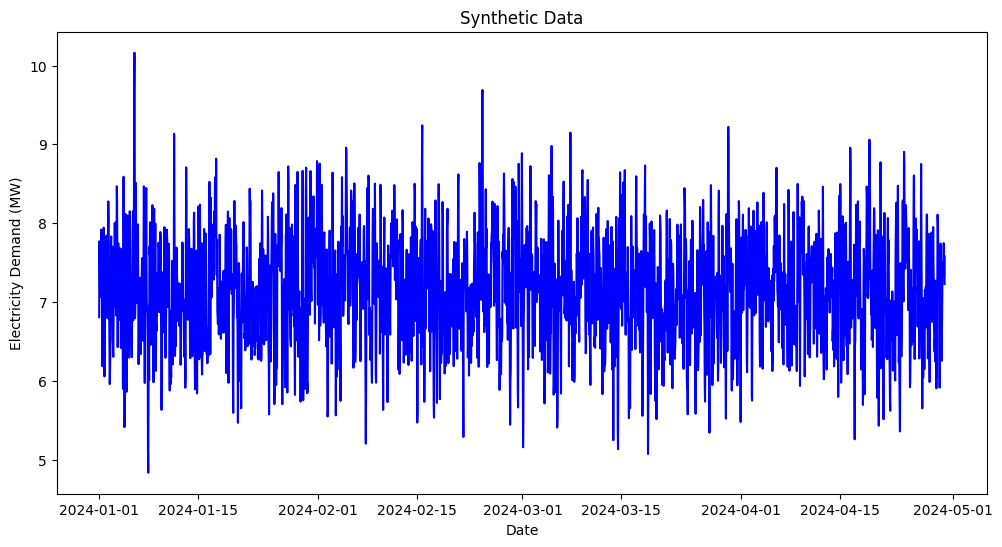

In [109]:
# Plot the generated demand series (for visual inspection)
plt.figure(figsize=(12, 6))
plt.plot(data_series, color='blue')
plt.title('Synthetic Data')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.show()

In [110]:
# Check for stationarity
adf_result = adfuller(data_series)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -23.5860871240931
p-value: 0.0


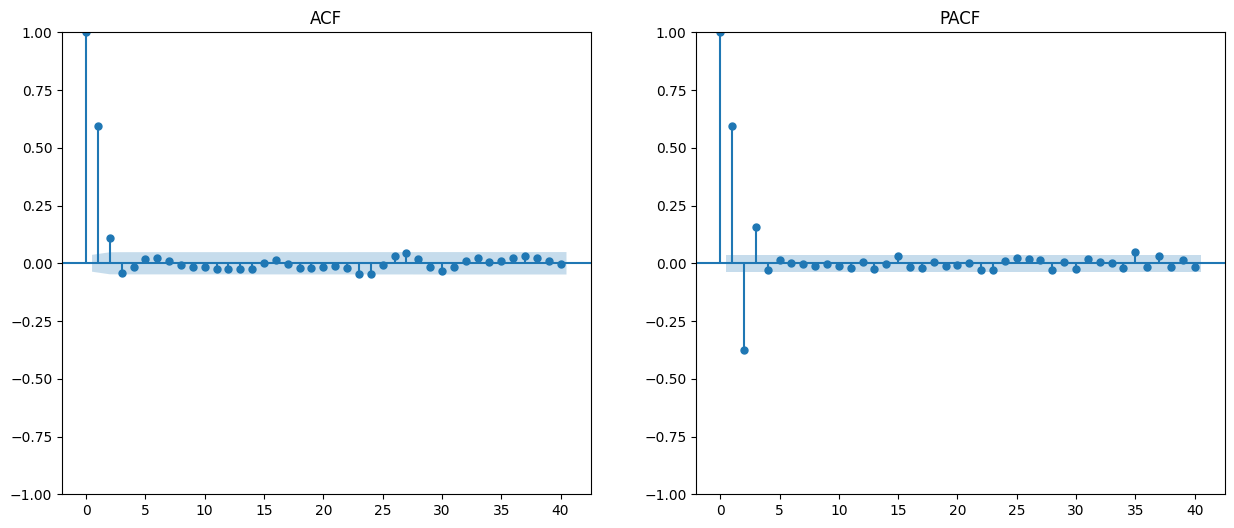

In [111]:
# Plot ACF and PACF
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sm.graphics.tsa.plot_acf(data_series, lags=40, ax=axs[0])
axs[0].set_title('ACF')
sm.graphics.tsa.plot_pacf(data_series, lags=40, ax=axs[1])
axs[1].set_title('PACF')

plt.show()

In [112]:
# Split the data into training and test sets 
train_size = int(len(data_series) * 0.99)
train, test = data_series[:train_size], data_series[train_size:]

In [113]:
# Fit an ARMA(3,2) and ARMA(2,1) models to the training data
model_arma32 = ARIMA(train, order=(3, 0, 2))
model_fit_arma32 = model_arma32.fit()
forecast_arma32 = model_fit_arma32.predict(start=len(train), end=len(train) + len(test) - 1)

model_arma12 = ARIMA(train, order=(2, 0, 1))
model_fit_arma12 = model_arma12.fit()
forecast_arma12 = model_fit_arma12.predict(start=len(train), end=len(train) + len(test) - 1)

In [114]:
# Compare 
model_fit_arma32 = model_arma32.fit()
model_fit_arma12 = model_arma12.fit()

# Calculate AIC and BIC 
aic_arma32 = round(model_fit_arma32.aic, 2)
bic_arma32 = round(model_fit_arma32.bic, 2)
aic_arma12 = round(model_fit_arma12.aic, 2)
bic_arma12 = round(model_fit_arma12.bic, 2)

print(f'ARMA(3,2) - AIC: {aic_arma32}, BIC: {bic_arma32}')
print(f'ARMA(2,1) - AIC: {aic_arma12}, BIC: {bic_arma12}')

# Calculate MSE
mse_arma32_manual = np.mean((test - forecast_arma32) ** 2)
mse_arma12_manual = np.mean((test - forecast_arma12) ** 2)

print(f'Mean Squared Error (MSE) for ARMA(3,2): {mse_arma32_manual:.5f}')
print(f'Mean Squared Error (MSE) for ARMA(2,1): {mse_arma12_manual:.5f}')

ARMA(3,2) - AIC: 4152.44, BIC: 4194.12
ARMA(2,1) - AIC: 4151.67, BIC: 4181.44
Mean Squared Error (MSE) for AR(3,2): 0.30056
Mean Squared Error (MSE) for AR(2,1): 0.29864


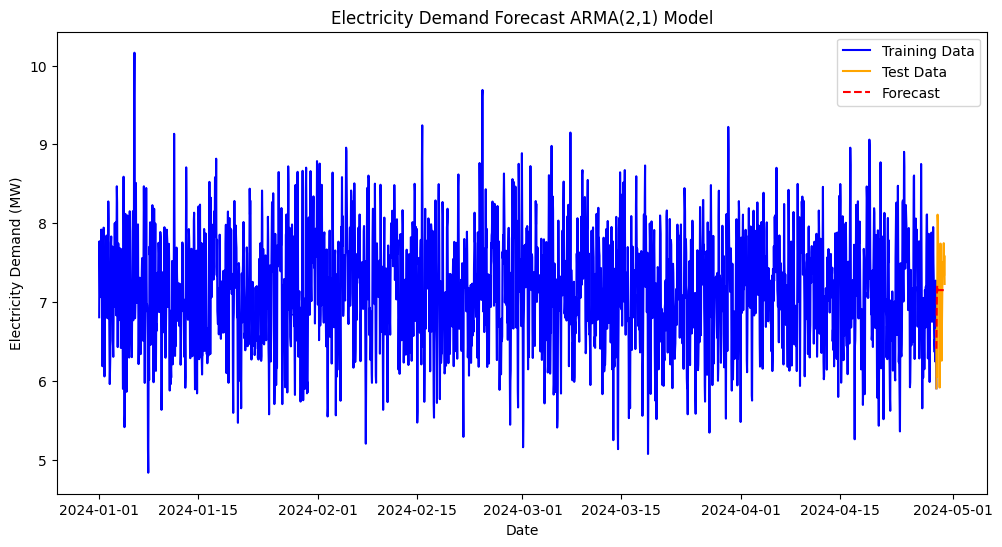

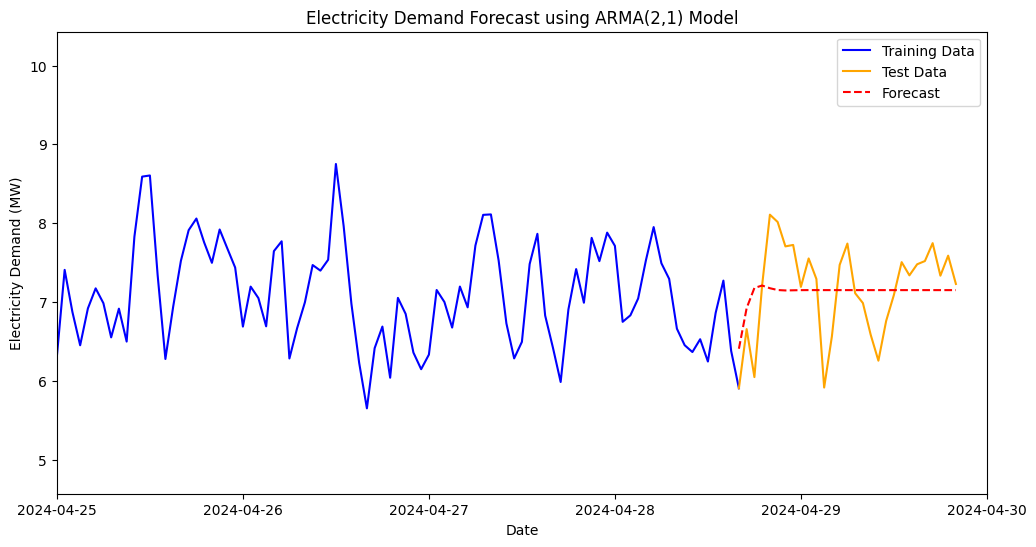

In [115]:
# Use the ARMA(2,1) model visualise preds

# For visual purposes, extend the training data with the first value of the test set
first_test_value = pd.Series([test.iloc[0]], index=[test.index[0]])
extended_train = pd.concat([train, first_test_value])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(extended_train.index, extended_train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(forecast_arma12.index, forecast_arma12, label='Forecast', color='red', linestyle='--')  
plt.title('Electricity Demand Forecast ARMA(2,1) Model') 
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(extended_train.index, extended_train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(forecast_arma12.index, forecast_arma12, label='Forecast', color='red', linestyle='--') 
plt.xlim([pd.Timestamp('2024-04-25'), pd.Timestamp('2024-04-30')])  
plt.title('Electricity Demand Forecast using ARMA(2,1) Model') 
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()